## Classification

In [28]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV ,cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [26]:
# Data loading
df = pd.read_csv('rwsi_data.csv')

print("RETAIL WEB SESSION INTELLIGENCE (RWSI) DATA ANALYSIS")

# Basic dataset information
print(f"\n Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(list(df.columns))

print(f"\nTarget variable distribution:")
print(df['MonetaryConversion'].value_counts())

RETAIL WEB SESSION INTELLIGENCE (RWSI) DATA ANALYSIS

 Dataset loaded successfully!
Dataset shape: (12330, 20)

Column names:
['SessionID', 'AdClicks', 'InfoSectionCount', 'InfoSectionTime', 'HelpPageVisits', 'HelpPageTime', 'ItemBrowseCount', 'ItemBrowseTime', 'ExitRateFirstPage', 'SessionExitRatio', 'PageEngagementScore', 'HolidayProximityIndex', 'VisitMonth', 'UserPlatformID', 'WebClientCode', 'MarketZone', 'TrafficSourceCode', 'UserCategory', 'IsWeekendVisit', 'MonetaryConversion']

Target variable distribution:
MonetaryConversion
No     10422
Yes     1908
Name: count, dtype: int64


In [30]:
print(f"DataFrame type: {type(df)}")
print(f"DataFrame shape: {df.shape}")
print("First 5 rows of the dataset:")
df.head()

DataFrame type: <class 'pandas.core.frame.DataFrame'>
DataFrame shape: (12330, 20)
First 5 rows of the dataset:


,SessionID,AdClicks,InfoSectionCount,InfoSectionTime,HelpPageVisits,HelpPageTime,ItemBrowseCount,ItemBrowseTime,ExitRateFirstPage,SessionExitRatio,PageEngagementScore,HolidayProximityIndex,VisitMonth,UserPlatformID,WebClientCode,MarketZone,TrafficSourceCode,UserCategory,IsWeekendVisit,MonetaryConversion
0,jv3uDyqYltpoXreO,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,February,Windows,Safari,North America,1.0,Returning,False,No
1,eBHG5YGyco8TRlac,4.0,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,February,Android,Chrome,NaN,2.0,Returning,False,No
2,Lz5fuqr91SKGHb5N,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,February,MacOS,Safari,Other,3.0,Returning,False,No
3,cyOsumxkpNEvKIdc,4.0,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,February,iOS,NaN,Europe,4.0,Returning,False,No
4,F4rTMKOqtoPKzxw9,2.0,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,NaN,February,iOS,Internet Explorer,NaN,4.0,Returning,True,No


In [16]:
# Analysis of missing values
print(" Analyzing missing values...")
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(f"\nMissing Values Summary:\n{missing_data}")

 Analyzing missing values...

Missing Values Summary:
                                      Column  Missing_Count  \
AdClicks                            AdClicks            863   
WebClientCode                  WebClientCode            616   
TrafficSourceCode          TrafficSourceCode            616   
MarketZone                        MarketZone            616   
UserPlatformID                UserPlatformID            493   
ItemBrowseCount              ItemBrowseCount            493   
ItemBrowseTime                ItemBrowseTime            493   
HolidayProximityIndex  HolidayProximityIndex            493   
UserCategory                    UserCategory            493   
InfoSectionCount            InfoSectionCount            369   
PageEngagementScore      PageEngagementScore            369   
InfoSectionTime              InfoSectionTime            369   
HelpPageVisits                HelpPageVisits            246   
HelpPageTime                    HelpPageTime            246   
S

In [17]:
# Data Preprocessing
print("Preprocessing data...")
df_processed = df.copy()

# Handle missing values in numerical columns
numerical_cols_with_missing = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols_with_missing:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)

# Handle missing values in categorical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'SessionID' and col != 'MonetaryConversion':
        if df_processed[col].isnull().sum() > 0:
            mode_val = df_processed[col].mode()[0] if len(df_processed[col].mode()) > 0 else 'Unknown'
            df_processed[col].fillna(mode_val, inplace=True)

# Drop SessionID
df_processed = df_processed.drop('SessionID', axis=1)

# Convert target to binary
df_processed['MonetaryConversion'] = (df_processed['MonetaryConversion'] == 'Yes').astype(int)
print(f" Data preprocessing completed")
print(f" Missing values remaining: {df_processed.isnull().sum().sum()}")

Preprocessing data...
 Data preprocessing completed
 Missing values remaining: 0


In [18]:
# Feature Engineering
print("Engineering features...")
df_processed['TotalHelpEngagement'] = df_processed['HelpPageVisits'] + df_processed['InfoSectionCount']
df_processed['AvgHelpPageTime'] = df_processed['HelpPageTime'] / (df_processed['HelpPageVisits'] + 1)
df_processed['AvgInfoSectionTime'] = df_processed['InfoSectionTime'] / (df_processed['InfoSectionCount'] + 1)
df_processed['AvgItemBrowseTime'] = df_processed['ItemBrowseTime'] / (df_processed['ItemBrowseCount'] + 1)
df_processed['TotalEngagementScore'] = (df_processed['PageEngagementScore'] + df_processed['ItemBrowseTime'] + 
                                         df_processed['HelpPageTime'] + df_processed['InfoSectionTime']) / 4
df_processed['BrowseToHelpRatio'] = df_processed['ItemBrowseCount'] / (df_processed['TotalHelpEngagement'] + 1)
df_processed['SessionActivityLevel'] = (df_processed['AdClicks'] + df_processed['ItemBrowseCount'] + 
                                         df_processed['TotalHelpEngagement'])
df_processed['ExitRiskScore'] = (df_processed['ExitRateFirstPage'] + df_processed['SessionExitRatio']) / 2
print(f" 8 new features created")

# ENCODE CATEGORICAL VARIABLES
print(" Encoding categorical variables...")
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
print(f" {len(categorical_features)} categorical variables encoded")

Engineering features...
 8 new features created
 Encoding categorical variables...
 5 categorical variables encoded


## EDA


Percentages:
 MonetaryConversion
No     84.53%
Yes    15.47%
Name: count, dtype: object


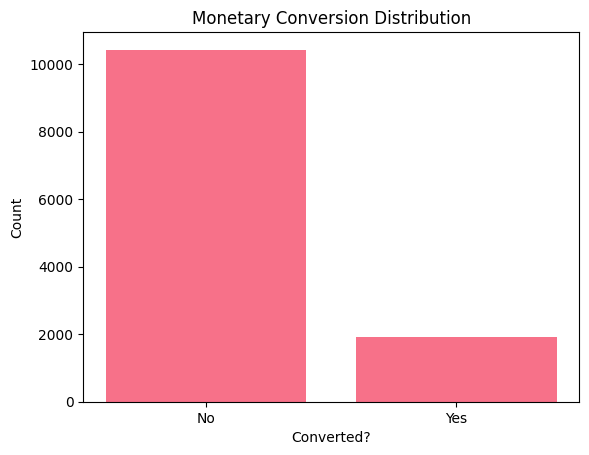

In [32]:
#Distributionof conversion rate
conversion_count = df['MonetaryConversion'].value_counts()

plt.bar(conversion_count.index, conversion_count.values)
plt.title('Monetary Conversion Distribution')
plt.xlabel('Converted?')
plt.ylabel('Count')
percentages = (conversion_count / len(df)) * 100
print("\nPercentages:\n", percentages.round(2).astype(str) + '%')
plt.show()

The Graph tells about the Imbalanced nature of Data, and the conversion rate is 15.5% which is low.

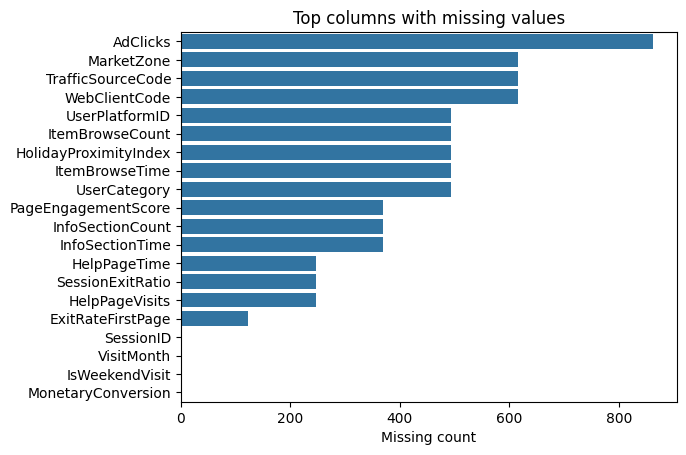

AdClicks
0.0    2344
3.0    2313
4.0    2291
1.0    2282
2.0    2237
Name: count, dtype: int64
Total number of values in AdClicks = 11467
Missing values = 863


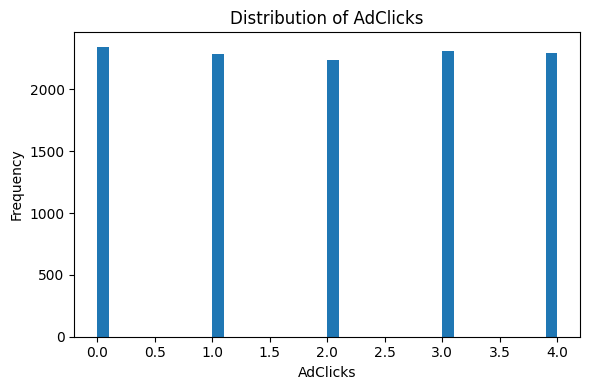

ItemBrowseTime
0.000000       722
17.000000       20
11.000000       17
8.000000        17
22.000000       15
              ... 
4845.989214      1
1445.840909      1
2674.339216      1
7453.766667      1
4269.493146      1
Name: count, Length: 9199, dtype: int64
Total number of values in ItemBrowseTime = 11837
Missing values = 493


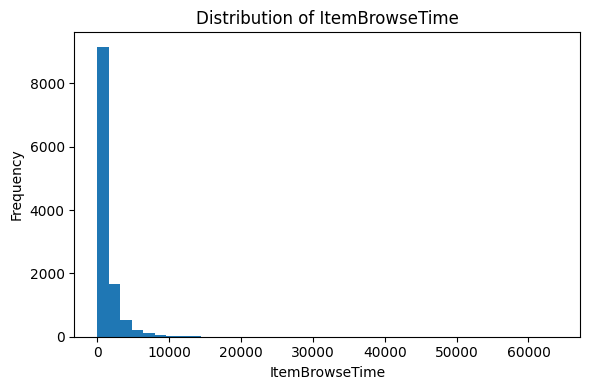

ItemBrowseCount
1.0      595
2.0      446
3.0      436
4.0      387
6.0      383
        ... 
378.0      1
254.0      1
183.0      1
210.0      1
192.0      1
Name: count, Length: 306, dtype: int64
Total number of values in ItemBrowseCount = 11837
Missing values = 493


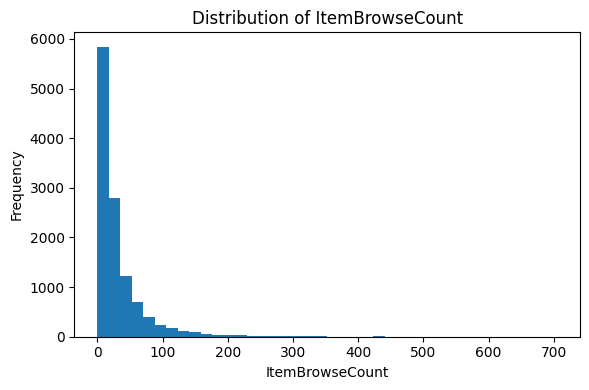

PageEngagementScore
0.000000     9317
53.988000       6
42.293068       3
15.395600       2
26.545500       2
             ... 
9.294776        1
6.871309        1
35.992615       1
53.134286       1
46.530175       1
Name: count, Length: 2618, dtype: int64
Total number of values in PageEngagementScore = 11961
Missing values = 369


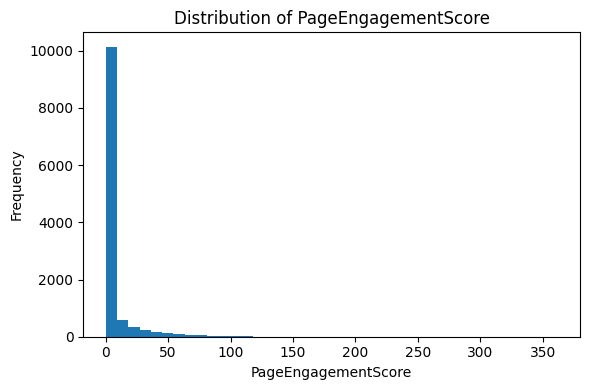

SessionExitRatio
0.200000    695
0.100000    333
0.050000    322
0.033333    286
0.066667    260
           ... 
0.020664      1
0.021904      1
0.012761      1
0.013953      1
0.015043      1
Name: count, Length: 4695, dtype: int64
Total number of values in SessionExitRatio = 12084
Missing values = 246


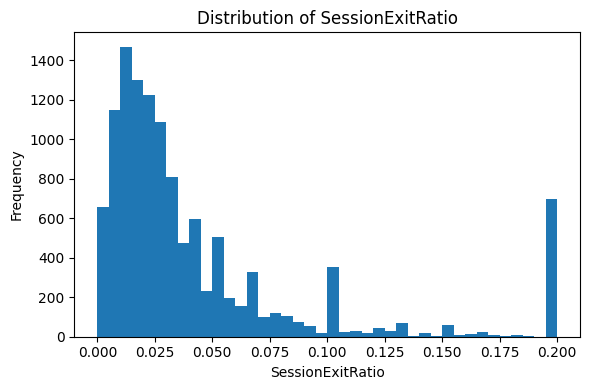

In [38]:
# Missing values
miss = df.isnull().sum().sort_values(ascending=False).head(20)
sns.barplot(x=miss.values, y=miss.index)
plt.title('Top columns with missing values')
plt.xlabel('Missing count'); plt.ylabel('')
plt.show()

# time spend before purchasing.
columns = ['AdClicks','ItemBrowseTime','ItemBrowseCount','PageEngagementScore','SessionExitRatio']
for col in columns:
    if col in df.columns:
        vals = df[col].dropna()
        plt.figure(figsize=(6,4))
        plt.hist(vals, bins=40)
        plt.title(f'Distribution of {col}')
        print(df[col].value_counts().sort_values(ascending=False))
        print(f'Total number of values in {col} = {df[col].count()}')
        print(f'Missing values = {df.shape[0] - df[col].count()}')
        plt.xlabel(col); plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

#

In [39]:
df['MonetaryConversion'] = df['MonetaryConversion'].map({'Yes': 1, 'No': 0})

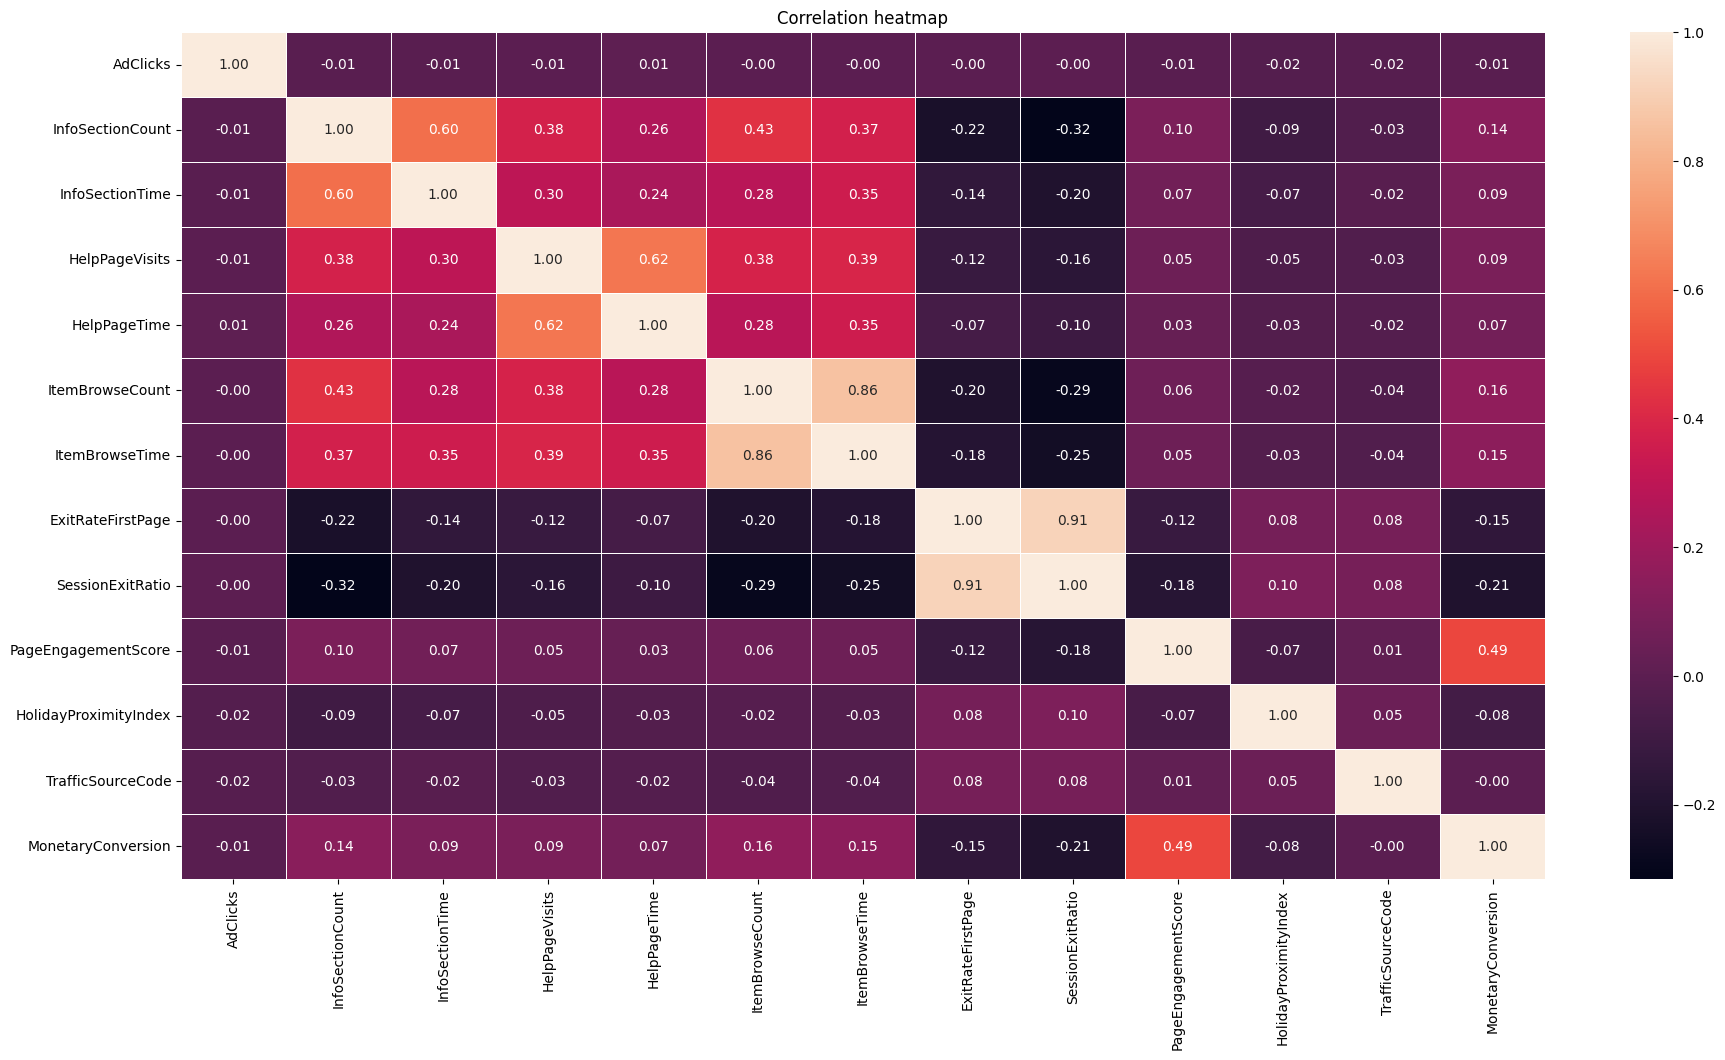

In [40]:
# Correlation matrix
num = df.select_dtypes(include=[np.number])
plt.figure(figsize=(22,11))
sns.heatmap(num.corr(), annot=True, fmt='.2f', linewidths=.5, cbar=True)
plt.title('Correlation heatmap')
plt.show()

This graphs tells us that:

- The two columns which are highly correlated are PageEngagementScore.
- The two columns which are very less correlated are HolidayProximityIndex

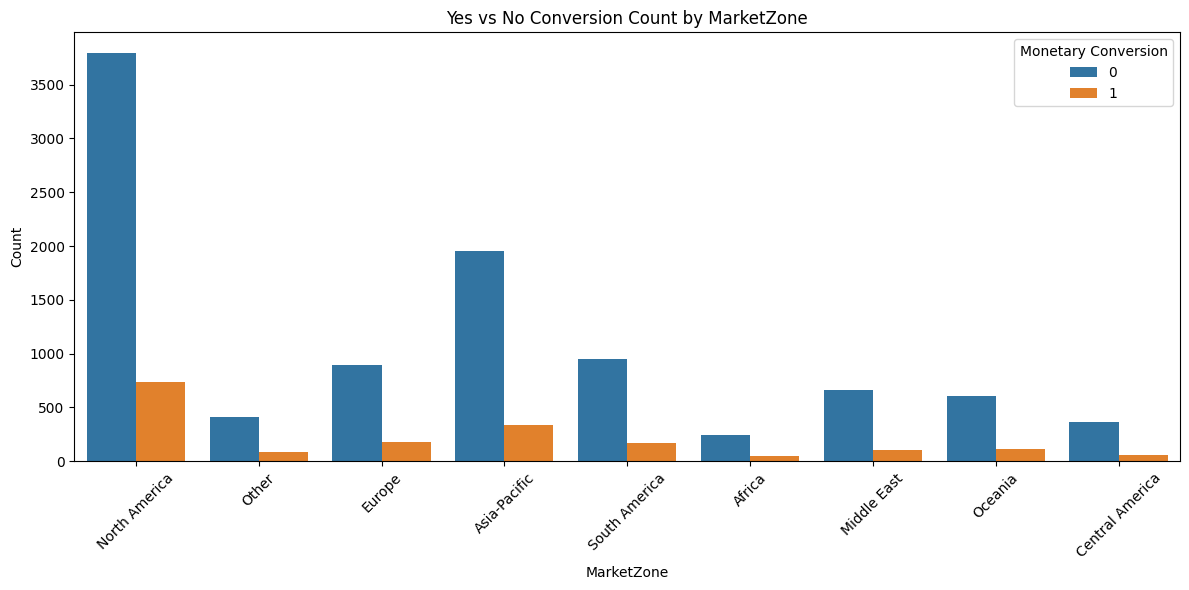

This graphs tells us the conversion rate according market zone. Africa and Europe are nearly equal and highest with MonetaryConversion.


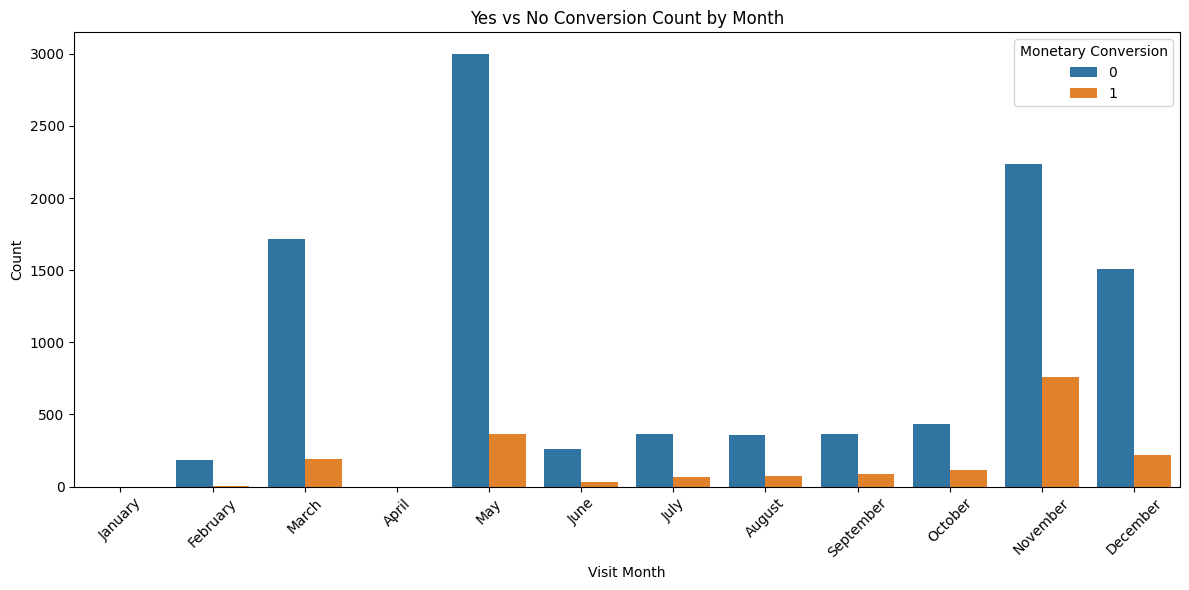

This graph tells us that people browse most of the time during winter or festive season.


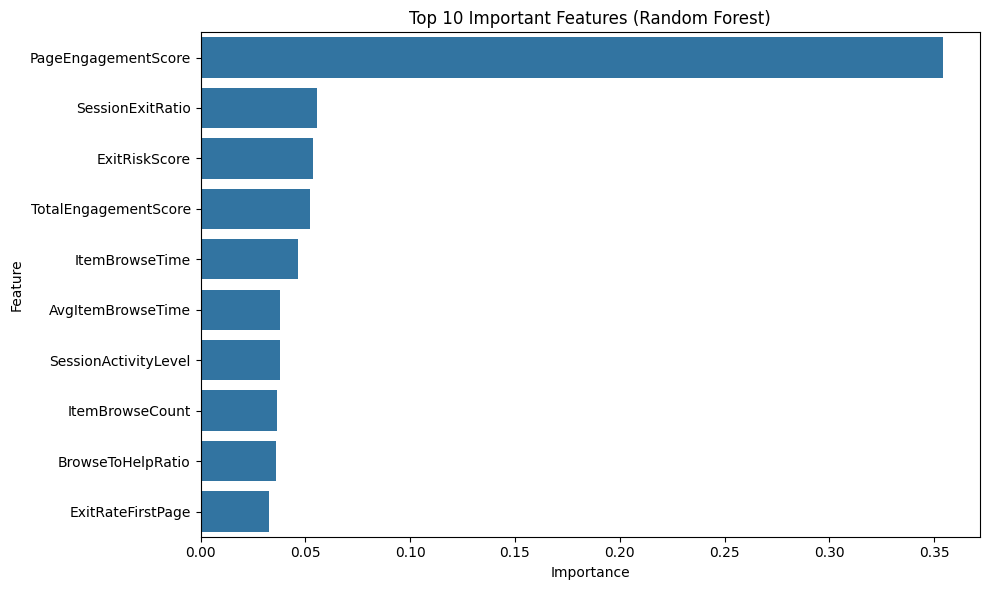

In [45]:
# Conversion rate by market zone
df['MonetaryConversion'] = df['MonetaryConversion'].astype(str).str.strip()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='MarketZone', hue='MonetaryConversion')

plt.title('Yes vs No Conversion Count by MarketZone')
plt.xlabel('MarketZone')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Monetary Conversion')
plt.tight_layout()
plt.show()
print("This graphs tells us the conversion rate according market zone. Africa and Europe are nearly equal and highest with MonetaryConversion.")

# Conversion rate by month
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']

df['MonetaryConversion'] = df['MonetaryConversion'].astype(str).str.strip()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='VisitMonth', hue='MonetaryConversion',
              order=month_order)

plt.title('Yes vs No Conversion Count by Month')
plt.xlabel('Visit Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Monetary Conversion')
plt.tight_layout()
plt.show()
print("This graph tells us that people browse most of the time during winter or festive season.")

# Feature Importance graph
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [33]:
# Train-Test Split and Scaling
print("Splitting and scaling data...")
X = df_processed.drop('MonetaryConversion', axis=1)
y = df_processed['MonetaryConversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f" Training set: {X_train.shape[0]} samples")
print(f" Testing set: {X_test.shape[0]} samples")


Splitting and scaling data...
 Training set: 9864 samples
 Testing set: 2466 samples


In [34]:
# MODEL TRAINING
print("Training models...")
models = {}

# Linear Regression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_scaled, y_train)
models['Linear Regression'] = lin_reg_model
y_pred_lin_reg = lin_reg_model.predict(X_test_scaled)
# Convert predictions to probabilities (clip between 0 and 1)
y_pred_proba_lin_reg = np.clip(y_pred_lin_reg, 0, 1)
print(" Linear Regression trained")

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
print(" Logistic Regression trained")

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_split=10)
dt_model.fit(X_train, y_train)
models['Decision Tree'] = dt_model
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]
print(" Decision Tree trained")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
print(" Random Forest trained")

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
models['Gradient Boosting'] = gb_model
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]
print(" Gradient Boosting trained")

print(f" All models trained successfully")

Training models...
 Linear Regression trained
 Logistic Regression trained
 Decision Tree trained
 Random Forest trained
 Gradient Boosting trained
 All models trained successfully


 Evaluating models...

MODEL EVALUATION RESULTS
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
  Linear Regression  0.870235   0.810000 0.212042  0.336100 0.863984
Logistic Regression  0.881590   0.764706 0.340314  0.471014 0.852778
      Decision Tree  0.879562   0.633229 0.528796  0.576320 0.852155
      Random Forest  0.894566   0.732824 0.502618  0.596273 0.899951
  Gradient Boosting  0.896594   0.715254 0.552356  0.623338 0.913544


<Figure size 1600x1000 with 0 Axes>

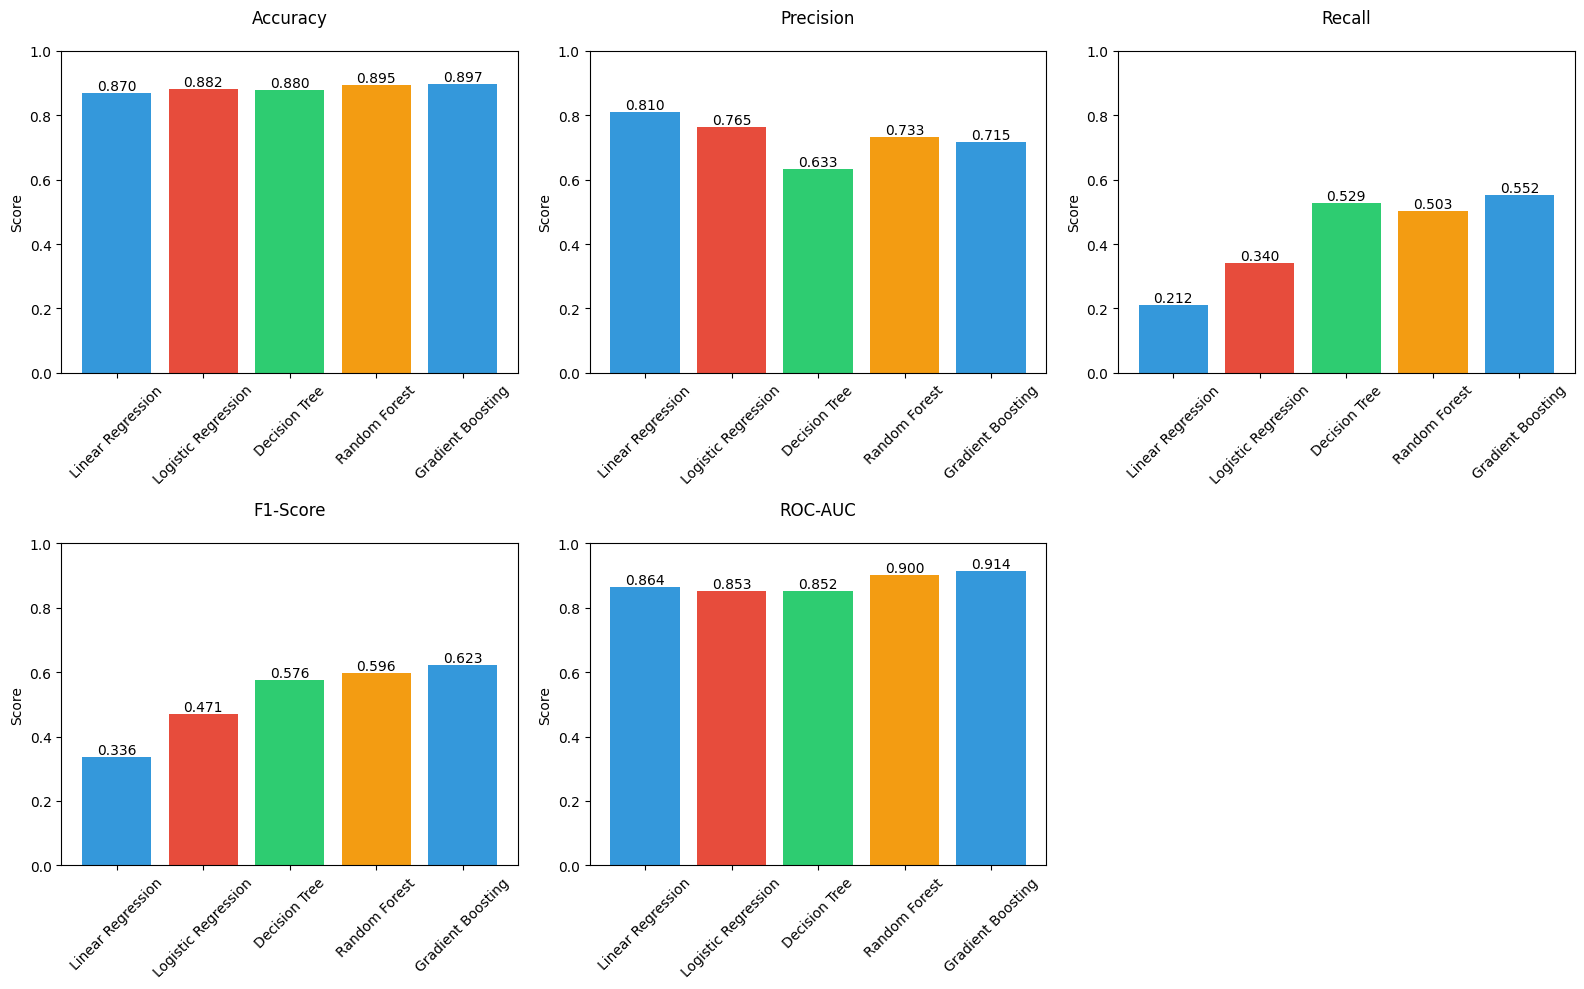

It is clearly visible here that Gradient Boosting gives best overall Performance.


In [35]:
# MODEL EVALUATION
print(" Evaluating models...")

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }

results = {}
results['Linear Regression'] = evaluate_model(y_test, (y_pred_lin_reg > 0.5).astype(int), y_pred_proba_lin_reg, 'Linear Regression')
results['Logistic Regression'] = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, 'Logistic Regression')
results['Decision Tree'] = evaluate_model(y_test, y_pred_dt, y_pred_proba_dt, 'Decision Tree')
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, 'Random Forest')
results['Gradient Boosting'] = evaluate_model(y_test, y_pred_gb, y_pred_proba_gb, 'Gradient Boosting')

results_df = pd.DataFrame(list(results.values()))

print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Create a figure with subplots
plt.figure(figsize=(16, 10))
plt.style.use('default')

# Define metrics and their positions
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
positions = [(0,0), (0,1), (0,2), (1,0), (1,1)]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# Create subplots for each metric
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.delaxes(axes[1,2])

# Plot each metric
for metric, pos in zip(metrics, positions):
    ax = axes[pos[0], pos[1]]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors)
    
    # Customize the plot
    ax.set_title(metric, pad=20)
    ax.set_ylabel('Score')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f'It is clearly visible here that {best_model} gives best overall Performance.')

In [46]:
# DETAILED ANALYSIS
print("Generating final report...")

model_predictions = {
    'Logistic Regression': (y_pred_lr, y_pred_proba_lr),
    'Decision Tree': (y_pred_dt, y_pred_proba_dt),
    'Random Forest': (y_pred_rf, y_pred_proba_rf),
    'Gradient Boosting': (y_pred_gb, y_pred_proba_gb)
}

for model_name, (y_pred, y_pred_proba) in model_predictions.items():
    print(f"\n{'='*60}")
    print(f"{model_name.upper()}")
    print(f"{'='*60}")
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Conversion', 'Conversion']))

# Best model selection
results_df['Average_Score'] = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean(axis=1)
best_overall = results_df.loc[results_df['Average_Score'].idxmax()]

print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest Model by Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']} ({results_df['Accuracy'].max():.4f})")
print(f"Best Model by F1-Score: {results_df.loc[results_df['F1-Score'].idxmax(), 'Model']} ({results_df['F1-Score'].max():.4f})")
print(f"Best Model by ROC-AUC: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']} ({results_df['ROC-AUC'].max():.4f})")
print(f" BEST OVERALL MODEL: {best_overall['Model']}")
print(f"   Average Score: {best_overall['Average_Score']:.4f}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_overall['ROC-AUC']:.4f}")

# Feature importance
print("\n" + "="*80)
print("TOP 10 IMPORTANT FEATURES (Random Forest)")
print("="*80)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)
print(rf_importance.to_string(index=False))

# Cross-validation
print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS (5-Fold)")
print("="*80)
for model_name, model in models.items():
    if model_name == 'Logistic Regression':
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"\n{model_name}:")
    print(f"  Mean F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# Final summary
print("\n" + "*"*80)
print("RWSI DATASET ANALYSIS - FINAL REPORT")
print("*"*80)

print(" Data Preprocessing: Complete")
print(" Feature Engineering: 8 new features created")
print(" Model Training: 4 models trained")
print(" Model Evaluation: Comprehensive metrics calculated")

print(f"\nDATASET OVERVIEW:")
print(f"   - Total Records: {len(df):,}")
print(f"   - Total Features: {X.shape[1]}")
print(f"   - Conversion Rate: {(y.sum() / len(y) * 100):.2f}%")

print(f"\nBEST PERFORMING MODEL: {best_overall['Model']}")
print(f"   - Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   - Precision: {best_overall['Precision']:.4f}")
print(f"   - Recall: {best_overall['Recall']:.4f}")
print(f"   - F1-Score: {best_overall['F1-Score']:.4f}")
print(f"   - ROC-AUC: {best_overall['ROC-AUC']:.4f}")

print("\nMODEL RANKINGS (by F1-Score):")
for idx, row in results_df.nlargest(4, 'F1-Score')[['Model', 'F1-Score']].iterrows():
    print(f"   {idx+1}. {row['Model']}: {row['F1-Score']:.4f}")

Generating final report...

LOGISTIC REGRESSION

Confusion Matrix:
[[2044   40]
 [ 252  130]]

Classification Report:
               precision    recall  f1-score   support

No Conversion       0.89      0.98      0.93      2084
   Conversion       0.76      0.34      0.47       382

     accuracy                           0.88      2466
    macro avg       0.83      0.66      0.70      2466
 weighted avg       0.87      0.88      0.86      2466


DECISION TREE

Confusion Matrix:
[[1967  117]
 [ 180  202]]

Classification Report:
               precision    recall  f1-score   support

No Conversion       0.92      0.94      0.93      2084
   Conversion       0.63      0.53      0.58       382

     accuracy                           0.88      2466
    macro avg       0.77      0.74      0.75      2466
 weighted avg       0.87      0.88      0.88      2466


RANDOM FOREST

Confusion Matrix:
[[2014   70]
 [ 190  192]]

Classification Report:
               precision    recall  f1-score  